In [23]:
import geopandas as gpd
import pandas as pd
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch_geometric.utils as tgutils

import pyproj
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

### Create a Dataset

this will create a custom pytorch dataset, which converts each building polygon to a graph structure on-the-fly when requested from the data loader

In [27]:
class BuildingFootprintsDataset(Dataset):
    def __init__(self, csv_path, transform=None, pre_transform=None):
        super(BuildingFootprintsDataset, self).__init__(transform, pre_transform)
        self.data_df = pd.read_csv(csv_path)
        self.proj = pyproj.Transformer.from_crs(4326, 3857)

    def len(self):
        return len(self.data_df['PolygonID'].unique())

    def get(self, idx):
        # Extract polygon vertices from csv (grouped by polygon id)
        polygon_id = self.data_df['PolygonID'].unique()[idx]
        vertices_df = self.data_df[self.data_df['PolygonID'] == polygon_id]

        # Sort vertices based on direction_sort column
        vertices_df = vertices_df.sort_values(by='direction_sort')

        # Convest lat-lon crs in degrees to a crs with meter unit
        vertices_df['coord_meter'] = vertices_df[['X', 'Y']].apply(lambda p: self.proj.transform(p.X, p.Y), axis=1)
        vertices_df[['X_meter','Y_meter']] = vertices_df['coord_meter'].apply(lambda p: pd.Series(np.array([p[0], p[1]]), index=["X_meter", "Y_meter"]))

        # For each polygon, translate its origin(0,0) to its centroid
        cen_X = vertices_df['X_meter'].mean()
        cen_Y = vertices_df['Y_meter'].mean()
        vertices_df['X_local'] = vertices_df['X_meter'].apply(lambda x: x-cen_X)
        vertices_df['Y_local'] = vertices_df['Y_meter'].apply(lambda y: y-cen_Y)

        vertices = vertices_df[['X_local','Y_local']].values
        labels = vertices_df['is_corner'].values

        # Create nodes and labels tensor
        node_features = torch.tensor(vertices, dtype=torch.float32) # use dtype=torch.float64 for increased precision
        labels = torch.tensor(labels, dtype=torch.long) # has to be dtype=torch.long for some reason

        # Create edges
        num_vertices = len(vertices)
        edge_indices = []
        for i in range(num_vertices):
            edge_indices.append([i, (i + 1) % num_vertices])  # Connect neighboring vertices
            edge_indices.append([(i + 1) % num_vertices, i])  # Add reverse direction, to get an undirected graph
        edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        # create graph structure
        data = Data(x=node_features, edge_index=edge_indices, y=labels)

        return data

### Using the dataset

In [28]:
dataset = BuildingFootprintsDataset('data/building_data.csv')

# Create a data loader for batching and shuffling
# from here on training process should be similar to 'classic' pytorch approach
loader = DataLoader(dataset, batch_size=32, shuffle=True)

### Plot sample from dataset

28
False


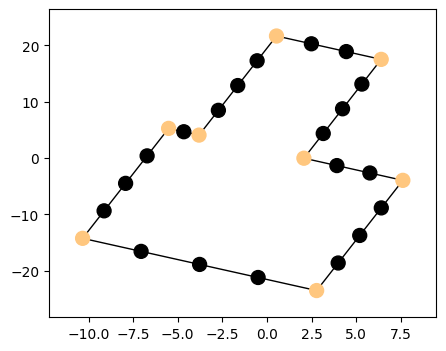

In [51]:
# take random dataset
data = dataset[125]

print(data.num_nodes)
print(data.is_directed())

pos = {}
for i, coords in enumerate(data.x.numpy()):
    pos[i] = (coords[0], coords[1])

# convert to networkx graph
g = to_networkx(data, to_undirected=True)

# plot networkx graph
fig, ax = plt.subplots(figsize=(5,4))
nx.draw(g, pos, node_size=100, node_color=data.y, cmap='copper')
plt.axis("on")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()